### Imports

In [1]:
first_time_importing_torch = True

In [2]:
import os

# NOTE: Importing torch the first time will always take a long time!
import time
# NOTE: Importing torch the first time will always take a long time!
if first_time_importing_torch:
    print(f"Importing torch ...")
    import_torch_start_time = time.time() 
import torch
if first_time_importing_torch:
    import_torch_end_time = time.time()
    print(f"Importing torch took {import_torch_end_time - import_torch_start_time} seconds")
    first_time_importing_torch = False

import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

# from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from skimage.metrics import structural_similarity
# from skimage.metrics import peak_signal_noise_ratio

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

# import wandb # Optional, for logging

import json
import yaml

Importing torch ...
Importing torch took 11.541084289550781 seconds


In [3]:
from metrics.metrics import SSIM, PSNR

In [4]:
from scripts.train import start_training

In [5]:
from data.get_data_loaders import get_data_loaders

In [6]:
from data.sidd_load_images import load_images_SIDD

In [7]:
from data.base_dataset import BaseDataset

In [8]:
from data.chest_xray_load_images import load_images_chest_xray
from data.chest_xray_dataset import ChestXrayDataset

In [9]:
from data.transform import crop_and_resize, convert_to_grayscale, convert_to_numpy, convert_to_tensor_4D, get_variable_noise, add_noise

In [10]:
from networks.unet_3d import UNet3d, DoubleConv, EncodeBlock3d, DecodeBlock3d

In [11]:
from networks.pdhg import PDHG
from networks.static_img_primal_dual_nn import StaticImagePrimalDualNN

# from importlib import reload

# def reload_modules():
#     modules = [
#         'networks.pdhg',
#         'networks.static_img_primal_dual_nn',
#     ]
#     for module in modules:
#         reload(sys.modules[module])

# reload_modules()

In [12]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/h/GIT/DISSERTATION/LearningRegularizationParameterMaps/venv_2/bin/python


Torch version: 2.3.1+cu121
Path: /mnt/h/GIT/DISSERTATION/LearningRegularizationParameterMaps/chest_xray


In [13]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [14]:
DISABLING_TESTS = False
# DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [15]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

torch.set_default_device(DEVICE)

Using NVIDIA GeForce RTX 4090


### CONFIG

In [16]:
SIDD_DATA_PATH = "../sidd/data/images/small/Data"

In [17]:
CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"

In [18]:
def get_config():
    CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"
    return {
        "project": "chest_xray",
        "dataset": CHEST_XRAY_BASE_DATA_PATH,
        "train_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL",
        "val_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/val/NORMAL",
        "test_data_path": f"{CHEST_XRAY_BASE_DATA_PATH}/test/NORMAL",
        "train_num_samples": 20,
        "val_num_samples": 8,
        "test_num_samples": 1,

        # "patch": 512,
        # "stride": 512,
        "resize_square": 256,
        "min_sigma": 0.1,
        "max_sigma": 0.5,
        "batch_size": 1,
        "random_seed": 42,

        "architecture": "UNET-PDHG",
        "in_channels": 1,
        "out_channels": 2,
        "init_filters": 16,
        "n_blocks": 2,
        "activation": "LeakyReLU",
        "downsampling_kernel": (2, 2, 1),
        "downsampling_mode": "max",
        "upsampling_kernel": (2, 2, 1),
        "upsampling_mode": "linear_interpolation",

        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "loss_function": "MSELoss",

        # "up_bound": 0.5,
        "up_bound": 0,
        "T": 16, # Higher T, NET does not have to try as hard? Less overfitting?

        "epochs": 2,
        "device": "cuda:0",

        "wandb_mode": "online",
        "save_epoch_wandb": 10_000,
        "save_epoch_local": 10,
        "save_dir": "tmp_2",
    }

print(get_config())

{'project': 'chest_xray', 'dataset': '../data/chest_xray', 'train_data_path': '../data/chest_xray/train/NORMAL', 'val_data_path': '../data/chest_xray/val/NORMAL', 'test_data_path': '../data/chest_xray/test/NORMAL', 'train_num_samples': 20, 'val_num_samples': 8, 'test_num_samples': 1, 'resize_square': 256, 'min_sigma': 0.1, 'max_sigma': 0.5, 'batch_size': 1, 'random_seed': 42, 'architecture': 'UNET-PDHG', 'in_channels': 1, 'out_channels': 2, 'init_filters': 16, 'n_blocks': 2, 'activation': 'LeakyReLU', 'downsampling_kernel': (2, 2, 1), 'downsampling_mode': 'max', 'upsampling_kernel': (2, 2, 1), 'upsampling_mode': 'linear_interpolation', 'optimizer': 'Adam', 'learning_rate': 0.0001, 'loss_function': 'MSELoss', 'up_bound': 0, 'T': 16, 'epochs': 2, 'device': 'cuda:0', 'wandb_mode': 'online', 'save_epoch_wandb': 10000, 'save_epoch_local': 10, 'save_dir': 'tmp_2'}


------

### Import the image and transform the data

#### Download the data

In [19]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

#### Load SIDD images

loading image id 0065, 1/1
(4048, 3044)


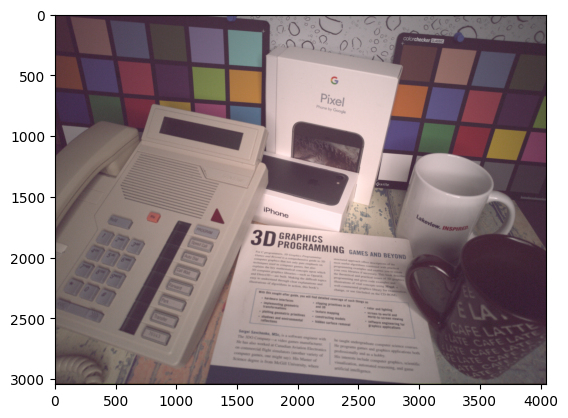

In [20]:
def test_load_images_SIDD():
    if DISABLING_TESTS: return
    images = load_images_SIDD(data_path=SIDD_DATA_PATH, ids=["0065"], from_npy_files=False)
    for img in images:
        print(img.size)
        plt.imshow(img)

test_load_images_SIDD()

#### Load Chest X-ray images

100%|██████████| 1/1 [00:00<00:00, 120.14it/s]


(2090, 1858)


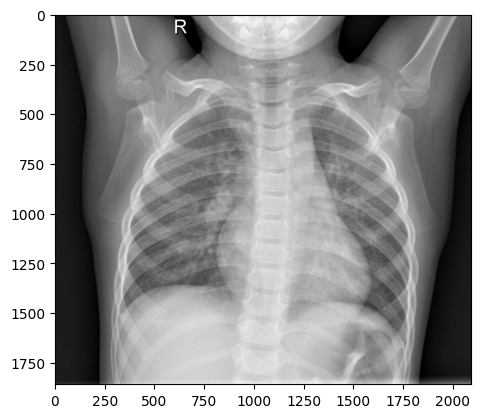

In [21]:
def test_load_images_chest_xray(stage="train", label="NORMAL"):
    if DISABLING_TESTS: return
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/{stage}/{label}", [0]):
        print(img.size)
        plt.imshow(img, cmap='gray')
    plt.show();

test_load_images_chest_xray()

------

#### Convert image to grayscale

100%|██████████| 1/1 [00:00<00:00, 184.03it/s]


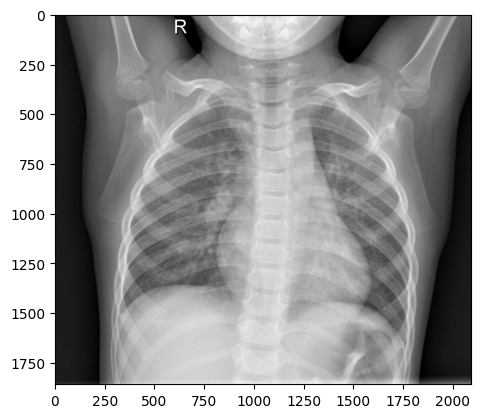

In [22]:
def test_convert_to_grayscale():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0065"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Transform image

100%|██████████| 1/1 [00:00<00:00, 202.36it/s]


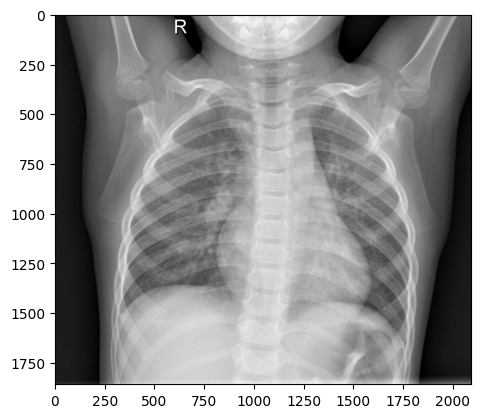

(120, 120)


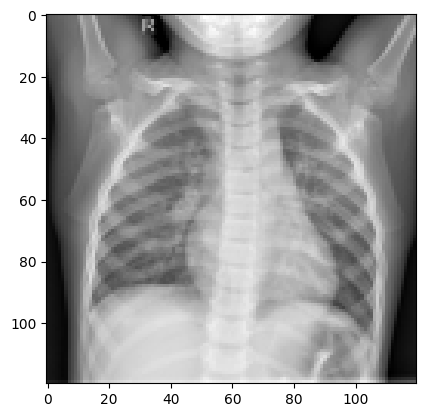

In [23]:
def test_crop_to_square_and_resize():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0083"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        plt.imshow(img, cmap='gray')
        plt.show();
        img = crop_and_resize(img, 120)
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.
        plt.show();

test_crop_to_square_and_resize()

100%|██████████| 1/1 [00:00<00:00, 189.75it/s]

Before conversion: <class 'PIL.Image.Image'>
After conversion: <class 'numpy.ndarray'>


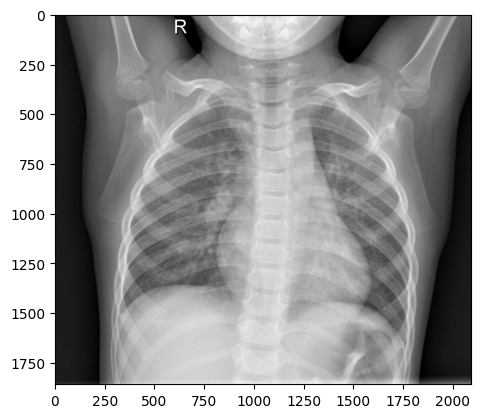

In [24]:
def test_convert_to_numpy():
    if DISABLING_TESTS: return
    # for img in load_images_SIDD(["0083"], False):
    for img in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

100%|██████████| 1/1 [00:00<00:00, 195.08it/s]


torch.Size([1, 1858, 2090, 1])


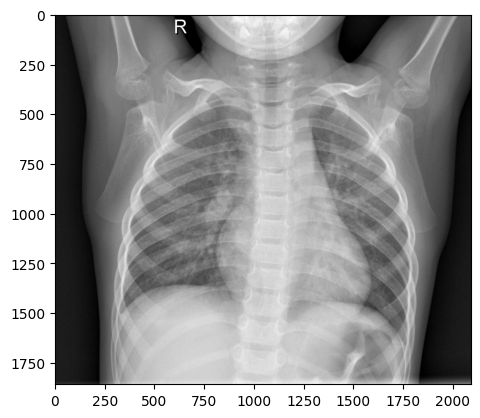

In [25]:
def test_convert_to_tensor():
    if DISABLING_TESTS: return
    # for image in load_images_SIDD(["0083"], False):
    for image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        image = convert_to_grayscale(image)
        image_numpy = convert_to_numpy(image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(image_tensor_4D.size())
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')


test_convert_to_tensor()

100%|██████████| 1/1 [00:00<00:00, 203.89it/s]

grayscale_image.size: (120, 120)


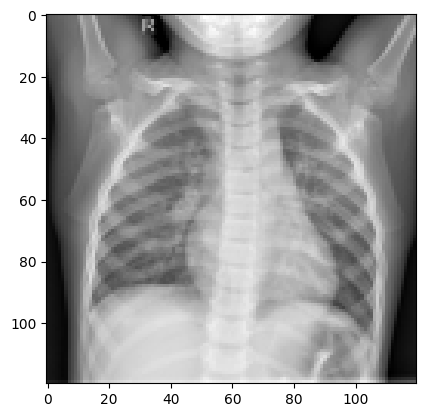

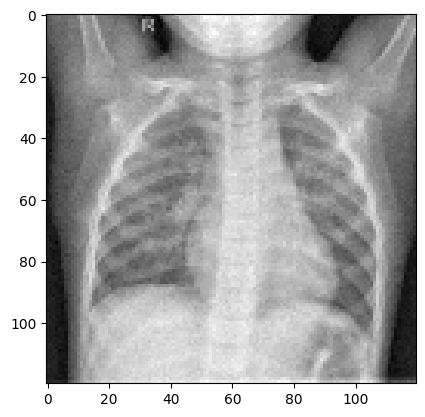

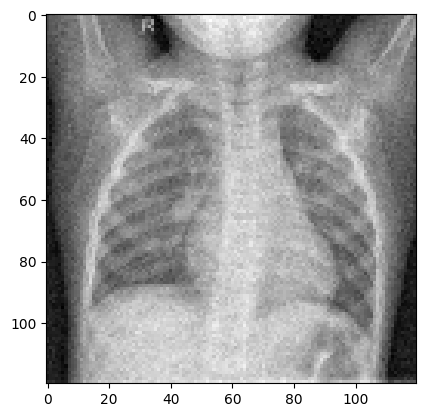

In [26]:
def test_add_noise():
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_and_resize(grayscale_image, 120)
        print(f"grayscale_image.size: {grayscale_image.size}")
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        constant_noise_img = add_noise(image_tensor_4D, sigma=0.1)
        variable_noise_img = add_noise(image_tensor_4D, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(grayscale_image, cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()
        
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

100%|██████████| 1/1 [00:00<00:00, 186.73it/s]

PSNR of original image: 100 dB


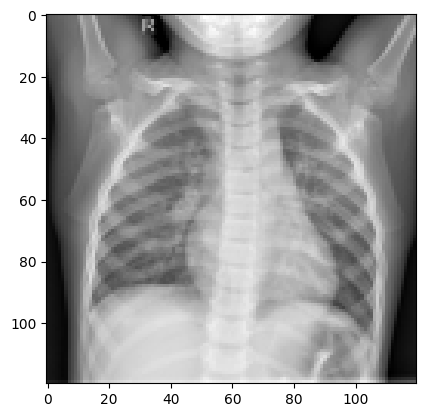

PSNR of constant noise image: 19.63 dB


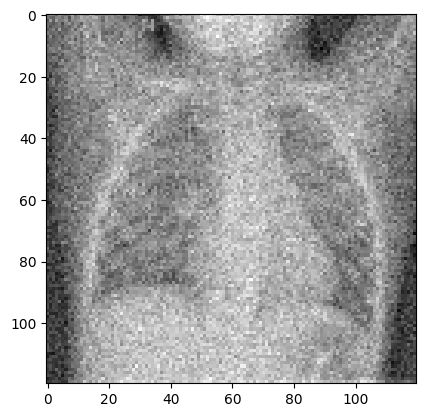

In [27]:
def test_PSNR():
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_and_resize(grayscale_image, 120)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        print(f"PSNR of original image: {PSNR(image_tensor_4D, image_tensor_4D)} dB")
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=0.5)
        print(f"PSNR of constant noise image: {PSNR(noisy_image_tensor_4D, image_tensor_4D):.2f} dB")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();


test_PSNR()

---

### Calculate SSIM

100%|██████████| 1/1 [00:00<00:00, 186.02it/s]

image_tensor_2D: torch.Size([120, 120])
SSIM of original image: 1.0


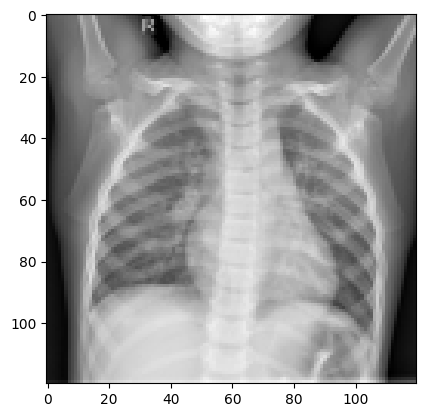

noisy_image_tensor_2D: torch.Size([120, 120])
SSIM of noisy image (sigma=0.5): 0.42


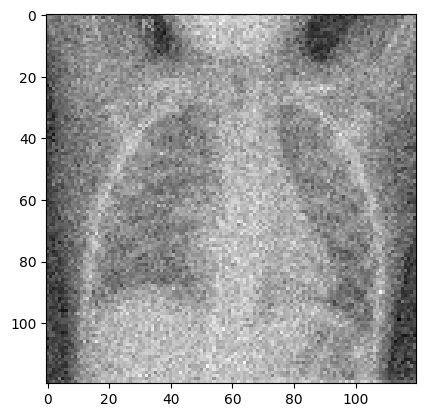

In [28]:
def test_SSIM(sigma=0.5):
    if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_and_resize(grayscale_image, 120)
        image_numpy = convert_to_numpy(grayscale_image)
        image_tensor_4D = convert_to_tensor_4D(image_numpy)

        image_tensor_2D = image_tensor_4D.squeeze(0).squeeze(-1)
        print(f"image_tensor_2D: {image_tensor_2D.size()}")
        print(f"SSIM of original image: {SSIM(image_tensor_2D, image_tensor_2D)}")
        plt.imshow(image_tensor_2D.cpu(), cmap='gray')
        plt.show();

        noisy_image_tensor_2D = add_noise(image_tensor_2D, sigma=sigma)
        print(f"noisy_image_tensor_2D: {noisy_image_tensor_2D.size()}")
        print(f"SSIM of noisy image (sigma={sigma}): {SSIM(noisy_image_tensor_2D, image_tensor_2D):.2f}")
        plt.imshow(noisy_image_tensor_2D.cpu(), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

test_SSIM()

------

### Reconstruct an image with PDHG

100%|██████████| 1/1 [00:00<00:00, 184.40it/s]


Image tensor size: torch.Size([1, 512, 512, 1])


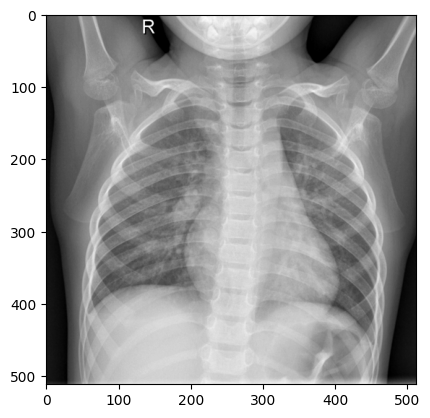

PSNR of constant noise image: 19.44 dB
SSIM of constant noise image: 0.19


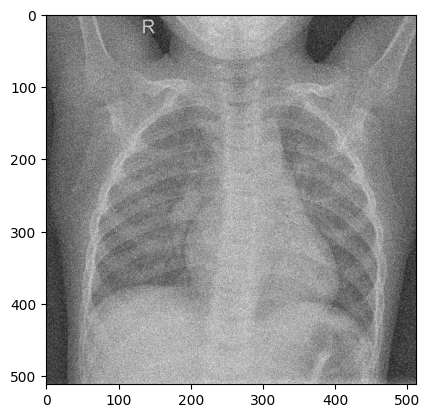

PDHG input size: torch.Size([1, 1, 512, 512, 1])
PSNR of reconstructed image: 27.76 dB


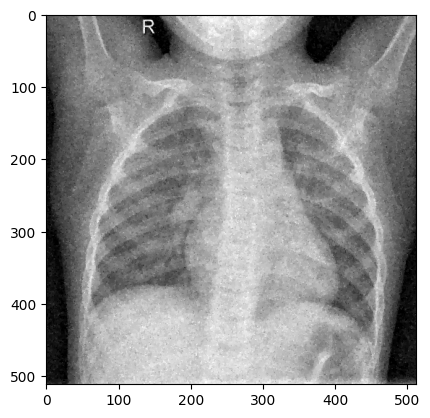


In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.



In [29]:
def test_reconstruct_with_PDHG():
    # if DISABLING_TESTS: return
    # for rgb_image in load_images_SIDD(["0083"], False):
    for rgb_image in load_images_chest_xray(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL", [0]):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = crop_and_resize(grayscale_image, 512)
        image_numpy = convert_to_numpy(grayscale_image)

        image_tensor_4D = convert_to_tensor_4D(image_numpy)
        print(f"Image tensor size: {image_tensor_4D.size()}")
        assert len(image_tensor_4D.size()) == 4, "The image should be 4D"
        plt.imshow(image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        noisy_image_tensor_4D = add_noise(image_tensor_4D, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_tensor_4D, noisy_image_tensor_4D):.2f} dB")
        print(f"SSIM of constant noise image: {SSIM(image_tensor_4D.squeeze(0).squeeze(-1), noisy_image_tensor_4D.squeeze(0).squeeze(-1)):.2f}")
        plt.imshow(noisy_image_tensor_4D.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_LAMBDA = 0.04
        pdhg_input_tensor_5D = noisy_image_tensor_4D.unsqueeze(0)
        print(f"PDHG input size: {pdhg_input_tensor_5D.size()}")
        assert len(pdhg_input_tensor_5D.size()) == 5, "The input for PDHG should be 5D"

        pdhg = PDHG()
        denoised_image_tensor_5D = pdhg(
            pdhg_input_tensor_5D, 
            lambda_reg=TEST_LAMBDA, 
            T=128)
        
        denoised_image_tensor_5D = torch.clamp(denoised_image_tensor_5D, 0, 1) # Clip the values to 0 and 1
        psnr_value_denoised = PSNR(image_tensor_4D, denoised_image_tensor_5D.squeeze(0))
        print(f"PSNR of reconstructed image: {psnr_value_denoised:.2f} dB")
        denoised_image_numpy_3D = denoised_image_tensor_5D.squeeze(0).squeeze(0).to("cpu").detach().numpy()
        plt.imshow(denoised_image_numpy_3D, cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()

### Test UNET

In [30]:
def assert_and_clear_cuda(expected, actual):
    try:
        assert expected == actual
    except AssertionError:
        print(f"!!! ERROR !!! Expected: {expected}, got {actual}")
        with torch.no_grad():
            torch.cuda.empty_cache()
    

def test_unet_3d():  
    if DISABLING_TESTS: return  
    input_tensor = torch.randn(1, 1, 512, 512, 1)  # batch size of 1, 1 channel, 512x512x1 volume
    
    config = get_config()

    # Example usage
    model = UNet3d(
        init_filters=32,
        n_blocks=config["n_blocks"],
        activation="ReLU",
        downsampling_kernel=(2, 2, 1),
        downsampling_mode=config["downsampling_mode"],
        upsampling_kernel=(2, 2, 1),
        upsampling_mode=config["upsampling_mode"],
    )
    output = model(input_tensor)
    print(f"UNet output shape: {output.shape}")
    assert_and_clear_cuda((1, 2, 512, 512, 1), output.shape)


    conv_3d = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1)
    conv_3d_output = conv_3d(input_tensor)
    print(f"Conv3d output shape: {conv_3d_output.shape}")
    assert_and_clear_cuda((1, 64, 512, 512, 1), conv_3d_output.shape)


    double_conv_3d = DoubleConv(64, 128)
    double_conv_output = double_conv_3d(conv_3d_output)
    print(f"{DoubleConv.__name__} output shape: {double_conv_output.shape}")
    assert_and_clear_cuda((1, 128, 512, 512, 1), double_conv_output.shape)


    max_3d = nn.MaxPool3d((3, 3, 1), stride=(2, 2, 1), padding=(1, 1, 0))
    max_3d_output_1 = max_3d(input_tensor)
    print(f"MaxPool3d output 1 shape: {max_3d_output_1.shape}")
    assert_and_clear_cuda((1, 1, 256, 256, 1), max_3d_output_1.shape)

    max_3d_input = torch.randn(1, 128, 512, 512, 1)
    max_3d_output_2 = max_3d(max_3d_input)
    print(f"MaxPool3d output 2 shape: {max_3d_output_2.shape}")
    assert_and_clear_cuda((1, 128, 256, 256, 1), max_3d_output_2.shape)

    conv_transpose_3d = nn.ConvTranspose3d(
        1024, 512, 
        kernel_size=(3, 3, 1), 
        stride=(2, 2, 1), 
        padding=(1, 1, 0), 
        output_padding=(1, 1, 0)
    )
    conv_transpose_3d_input = torch.randn(1, 1024, 32, 32, 1)
    conv_transpose_3d_output = conv_transpose_3d(conv_transpose_3d_input)
    print(f"ConvTranspose3d output shape: {conv_transpose_3d_output.shape}")
    assert_and_clear_cuda((1, 512, 64, 64, 1), conv_transpose_3d_output.shape)


    up_sample = nn.Upsample(
        scale_factor=(2, 2, 1), 
        mode='trilinear', align_corners=True) # What difference does it make if align_corners is True or False?
    up_sample_output = up_sample(input_tensor)
    print(f"Upsample output shape: {up_sample_output.shape}")
    assert_and_clear_cuda((1, 1, 1024, 1024, 1), up_sample_output.shape)
                    

    # # print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # # Delete the model and the output tensor
    # del model
    # del output
    # torch.cuda.empty_cache()

test_unet_3d()
with torch.no_grad():
    torch.cuda.empty_cache()

UNet output shape: torch.Size([1, 2, 512, 512, 1])
Conv3d output shape: torch.Size([1, 64, 512, 512, 1])
DoubleConv output shape: torch.Size([1, 128, 512, 512, 1])
MaxPool3d output 1 shape: torch.Size([1, 1, 256, 256, 1])
MaxPool3d output 2 shape: torch.Size([1, 128, 256, 256, 1])
ConvTranspose3d output shape: torch.Size([1, 512, 64, 64, 1])
Upsample output shape: torch.Size([1, 1, 1024, 1024, 1])


In [31]:
with torch.no_grad():
    torch.cuda.empty_cache()

------

### Create data loader

In [32]:
# Code adapted from ...

def get_datasets(config):
    min_sigma = config["min_sigma"]
    max_sigma = config["max_sigma"]
    resize_square = config["resize_square"]
    device = config["device"]

    train_num_samples = config["train_num_samples"]
    train_ids = list(range(0, train_num_samples))
    dataset_train = ChestXrayDataset(
        data_path=config["train_data_path"],
        ids=train_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    val_num_samples = config["val_num_samples"]
    val_ids = list(range(0, val_num_samples))
    dataset_valid = ChestXrayDataset(
        data_path=config["val_data_path"],
        ids=val_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    test_num_samples = config["test_num_samples"]
    test_ids = list(range(0, test_num_samples))
    dataset_test = ChestXrayDataset(
        data_path=config["test_data_path"],
        ids=test_ids,
        sigma=(min_sigma, max_sigma),
        resize_square=resize_square,
        # strides=[120, 120, 1],
        # patches_size=[120, 120, 1],
        # strides=[256, 256, 1], # stride < patch will allow overlapping patches, maybe good to blend the patches?
        # strides=[512, 512, 1],
        # patches_size=[512, 512, 1],
        device=device
    )

    print(f"Number of training samples: {len(dataset_train)}")
    print(f"Number of validation samples: {len(dataset_valid)}")
    print(f"Number of test samples: {len(dataset_test)}")

    return dataset_train, dataset_valid, dataset_test

#### Test data loader

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 223.80it/s]


Number of training samples: 20
Number of validation samples: 8
Number of test samples: 1
Batch 1
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


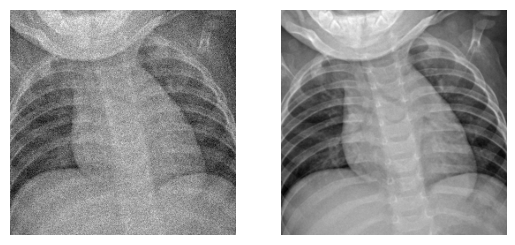

Batch 2
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


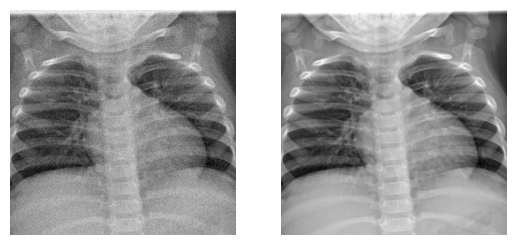

Batch 3
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


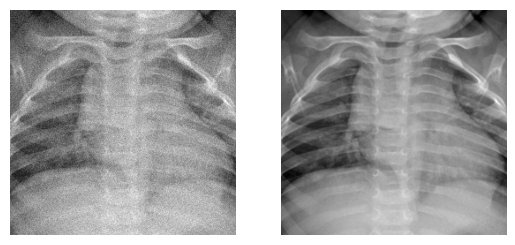

Batch 4
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


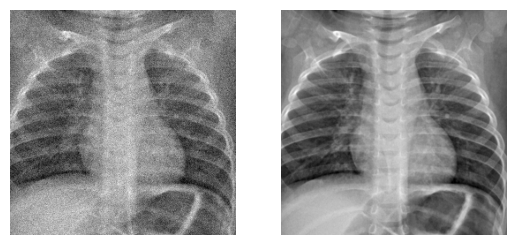

Batch 5
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


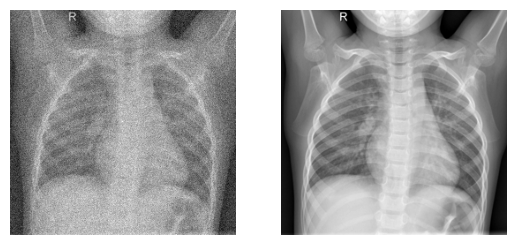

Batch 6
x size: torch.Size([1, 1, 256, 256, 1])
y size: torch.Size([1, 1, 256, 256, 1])


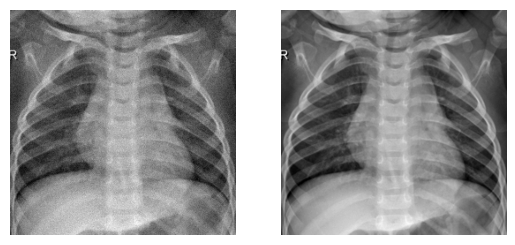

In [33]:
def test_dataloader():
    if DISABLING_TESTS: return
    data_loader_train, data_loader_valid, data_loader_test = get_data_loaders(get_config(), get_datasets)
    for i, (x, y) in enumerate(data_loader_train):
        print(f"Batch {i+1}")
        print(f"x size: {x.size()}")
        print(f"y size: {y.size()}")
        plt.subplot(1, 2, 1)
        plt.imshow(x.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(y.squeeze(0).squeeze(0).squeeze(-1).to("cpu"), cmap='gray')
        plt.axis('off')
        plt.show();
        if i == 5:
            break

    del data_loader_train, data_loader_valid, data_loader_test # Explicitly free up (GPU) memory to be safe

test_dataloader()

------

### Training

#### Prep for training

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [35]:
def save_image(image_tensor_2D, image_name, folder_name):
    image_tensor_2D = torch.clamp(image_tensor_2D, 0, 1) # Clip the values to 0 and 1
    image_numpy = image_tensor_2D.to("cpu").detach().numpy()
    image_numpy_256 = image_numpy * 255
    image_numpy_256_uint8 = image_numpy_256.astype(np.uint8)
    image_to_save = Image.fromarray(image_numpy_256_uint8)  # TODO: Is there a shorter way to do this, similar to .convert("L")?
    image_to_save.save(f"{folder_name}/{image_name}.png")

In [36]:
def make_testcase():
    CHEST_XRAY_BASE_DATA_PATH = "../data/chest_xray"
    image = Image.open(f"{CHEST_XRAY_BASE_DATA_PATH}/train/NORMAL/IM-0115-0001.jpeg")
    image = crop_and_resize(image, 512)

    folder_name = "testcases_tmp"

    image_name = "chest_xray_clean"
    image.save(f"{folder_name}/{image_name}.png") 

    # Add noise to the image
    noisy_image_tensor_4D = add_noise(convert_to_tensor_4D(convert_to_numpy(image)), sigma=0.5)
    noisy_image_tensor_2D = noisy_image_tensor_4D.squeeze(0).squeeze(-1)
    noisy_image_name = "chest_xray_noisy"
    save_image(noisy_image_tensor_2D, "chest_xray_noisy", folder_name)

    # Read the saved images
    clean_image = Image.open(f"{folder_name}/{image_name}.png")
    noisy_image = Image.open(f"{folder_name}/{noisy_image_name}.png")
    

    plt.subplot(1, 2, 1)
    plt.imshow(clean_image, cmap='gray')
    plt.axis('off')
    plt.title("Clean Image")
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')
    plt.title("Noisy Image")
    plt.show();

# make_testcase()

#### Optional: Use wandb to log the training process

In [37]:
# # Optional: Use wandb to log the training process
# # !wandb login
# def init_wandb(config):
#     project_name = config["project"]
#     os.environ['WANDB_NOTEBOOK_NAME'] = project_name
#     os.environ['WANDB_MODE'] = config["wandb_mode"] # https://docs.wandb.ai/quickstart
#     wandb.login()
#     # start a new wandb run to track this script
#     wandb.init(
#         # set the wandb project where this run will be logged
#         project=project_name,

#         # track hyperparameters and run metadata
#         config=get_config(),
#     )

In [38]:
# def temp_log_to_files():
#     model_states_dir = "tmp_2/model-chest_xray-2024_06_06_05_51_27"
#     config = get_config()
#     with open(f"{model_states_dir}/config.json", "w") as f:
#         json.dump(config, f, indent=4)
#     with open(f"{model_states_dir}/config.yaml", "w") as f:
#         yaml.dump(config, f)
#     with open(f"{model_states_dir}/config.txt", "w") as f:
#         f.write(str(config))

# def test_temp_log_to_files():
#     temp_log_to_files()

# test_temp_log_to_files()

#### Start training

In [39]:
with torch.no_grad():
    torch.cuda.empty_cache()

# reload_modules()
pdhg = start_training(get_config(), get_datasets)

with torch.no_grad():
    torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 191.02it/s]


Number of training samples: 20
Number of validation samples: 8
Number of test samples: 1


100%|██████████| 2/2 [00:06<00:00,  3.18s/it]


In [40]:
with torch.no_grad():
    torch.cuda.empty_cache()

------

### Inference

Demo the model

#### Test denoising

In [41]:
# # CODE TO INFER AND SHOW SOME RESULTS HERE



# def simple_plot(input_image_tensor_5D, subplot_index, image_name, clean_image_tensor_5D, folder_name, num_rows=2, num_cols=3):
#     plot_image_tensor_2D = input_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     psnr_value = PSNR(clean_image_tensor_2D, plot_image_tensor_2D)
#     ssim_value = SSIM(clean_image_tensor_2D, plot_image_tensor_2D)
#     plt.subplot(num_rows, num_cols, subplot_index)
#     plt.axis('off')
#     plt.imshow(plot_image_tensor_2D.to("cpu").detach().numpy(), cmap='gray')
#     plt.title(f"{image_name} PSNR: {psnr_value:.2f} dB\n{image_name} SSIM: {ssim_value:.2f}", fontsize=10)
#     # Write the image to a file
#     save_image(plot_image_tensor_2D, f"{image_name}", folder_name)

# def get_image_tensor_5D(image):
#     image = image.convert("L")
#     image_numpy = np.asarray(image)
#     image_tensor_4D = convert_to_tensor_4D(image_numpy)
#     image_tensor_5D = image_tensor_4D.unsqueeze(0).to(DEVICE)
#     return image_tensor_5D

# def denoise(pdhg: DynamicImageStaticPrimalDualNN, noisy_image_tensor_5D):
#     pdhg.eval()
#     with torch.no_grad():
#         best_lambda_map = pdhg.get_lambda_cnn(noisy_image_tensor_5D)
#     x_denoised_lambda_map_best_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda_map, pdhg.T)
#     # x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)
#     with torch.no_grad():
#         torch.cuda.empty_cache()
#     return best_lambda_map, x_denoised_lambda_map_best_tensor_5D


# def brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T, min_value=0.01, max_value=0.1, num_values=10):
#     # TODO: Brute-force single lambda
#     best_psnr = 0
#     best_lambda = 0
#     lambas = list(np.linspace(min_value, max_value, num_values))
#     psnr_values = []
#     for lambda_value in lambas:
#         with torch.no_grad():
#             x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, lambda_value, T)
#         psnr_value = PSNR(clean_image_tensor_5D, x_denoised_single_lambda_tensor_5D)
#         psnr_value = psnr_value.item()
#         # Convert to float
#         psnr_value = np.float64(psnr_value)
#         if psnr_value > best_psnr:
#             best_psnr = psnr_value
#             best_lambda = lambda_value
#         psnr_values.append(psnr_value)

#     # Plot the PSNR values
#     plt.plot(lambas, psnr_values)
#     plt.xlabel("Lambda")
#     plt.ylabel("PSNR")
#     plt.title("PSNR vs Lambda")
#     plt.show()
    
#     return best_lambda


# def test_denoise(pdhg: DynamicImageStaticPrimalDualNN=None, model_name="", best_lambda=None):
#     """
#     Testing denoising with pre-trained parameters.
#     """
#     clean_image = Image.open(f"testcases/chest_xray_clean.png")
#     noisy_image = Image.open(f"testcases/chest_xray_noisy.png")
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image)

#     if best_lambda is None:
#         best_lambda = brute_force_lambda(noisy_image_tensor_5D, clean_image_tensor_5D, T=pdhg.T, min_value=0.01, max_value=1, num_values=100)

#     print(f"Best lambda: {best_lambda}")

#     k_w, k_h = 256, 256

#     folder_name = f"./tmp/images/model_{model_name}-kernel_{k_w}-best_lambda_{str(best_lambda).replace('.', '_')}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
#     os.makedirs(folder_name, exist_ok=True)

#     plt.figure(figsize=(15, 6)) # Set the size of the plot

#     simple_plot(clean_image_tensor_5D, 1, "clean", clean_image_tensor_5D, folder_name)
#     simple_plot(noisy_image_tensor_5D, 2, "noisy", clean_image_tensor_5D, folder_name)

#     x_denoised_single_lambda_tensor_5D = reconstruct_with_PDHG(noisy_image_tensor_5D, best_lambda, T=pdhg.T)
    
#     best_lambda_map, x_denoised_lambda_map_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)

#     # Clip to [0, 1]. The calculations may make it slightly below 0 and above 1
#     x_denoised_single_lambda_tensor_5D = torch.clamp(x_denoised_single_lambda_tensor_5D, 0, 1)
#     x_denoised_lambda_map_tensor_5D = torch.clamp(x_denoised_lambda_map_tensor_5D, 0, 1)

#     simple_plot(x_denoised_single_lambda_tensor_5D, 3, f"single_lambda_best_{str(best_lambda).replace('.', '_')}", clean_image_tensor_5D, folder_name)
#     simple_plot(x_denoised_lambda_map_tensor_5D, 4, "lambda_map_best_using_function", clean_image_tensor_5D, folder_name)

#     lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#     lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#     lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]

#     lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#     lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#     lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#     simple_plot(lambda_map_1, 5, "lambda_map_1", clean_image_tensor_5D, folder_name)
#     simple_plot(lambda_map_3, 6, "lambda_map_3", clean_image_tensor_5D, folder_name)

#     plt.savefig(f"{folder_name}/results.png")

#     plt.show();

#     with open(f"{folder_name}/log.txt", "w") as f:
#         f.write(f"Best lambda: {best_lambda}\n")
#         f.write(f"PSNR (single lambda): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_single_lambda_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"PSNR (lambda map): {PSNR(clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1), x_denoised_lambda_map_tensor_5D.squeeze(0).squeeze(0).squeeze(-1))}\n")
#         f.write(f"Config: {get_config()}\n")

#     with torch.no_grad():
#         torch.cuda.empty_cache()

# model_dir = "./tmp_2/model-2024_06_05_23_51_27"
# epoch = 4000
# pdhg = torch.load(f"{model_dir}/model_epoch_{epoch}.pt")

# test_denoise(
#     pdhg=pdhg,
#     model_name=f"chest_xray_demo-epoch_{epoch}",
#     best_lambda=0.08
# )

# with torch.no_grad():
#     torch.cuda.empty_cache()

In [42]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [43]:
# def temp_test():

---

### Create a video

In [44]:
# def create_video(model_name, start_epoch=20, end_epoch=10_000, step=20):
#     clean_image_path = "./test_cases/turtle_clean/turtle clean.png"
#     noisy_image_path = "./test_cases/turtle_noisy/turtle noisy.png"
#     clean_image_tensor_5D = get_image_tensor_5D(clean_image_path)
#     noisy_image_tensor_5D = get_image_tensor_5D(noisy_image_path)
#     clean_image_tensor_2D = clean_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#     noisy_image_tensor_2D = noisy_image_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)

#     psnr_noisy = PSNR(noisy_image_tensor_2D, clean_image_tensor_2D)
#     ssim_noisy = SSIM(noisy_image_tensor_2D, clean_image_tensor_2D)



#     frames_folder = f"./tmp/{model_name}"
#     model_folder=f"./tmp_2/{model_name}"
#     os.makedirs(frames_folder, exist_ok=True)
#     os.makedirs(f"{frames_folder}/denoised", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_1", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_2", exist_ok=True)
#     os.makedirs(f"{frames_folder}/lambda_map_3", exist_ok=True)

#     with open(f"./tmp/{model_name}/metrics.csv", "w") as f:
#         f.write(f"Image, PSNR, SSIM\n")
#         f.write(f"Noisy, {psnr_noisy:.2f}, {ssim_noisy:.2f}\n")

#         for epoch in range(start_epoch, end_epoch + 1, step):
#             model_name = f"model_epoch_{epoch}"
#             pdhg = torch.load(f"{model_folder}/{model_name}.pt")
#             best_lambda_map, x_denoised_lambda_map_best_tensor_5D = denoise(pdhg, noisy_image_tensor_5D)
#             x_denoised_lambda_map_best_tensor_5D = torch.clamp(x_denoised_lambda_map_best_tensor_5D, 0, 1)

#             x_denoised_lambda_map_best_tensor_2D = x_denoised_lambda_map_best_tensor_5D.squeeze(0).squeeze(0).squeeze(-1)
#             psnr_denoised = PSNR(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             ssim_denoised = SSIM(x_denoised_lambda_map_best_tensor_2D, clean_image_tensor_2D)
#             f.write(f"{epoch}, {psnr_denoised:.2f}, {ssim_denoised:.2f}\n")

#             denoised_image_to_save = Image.fromarray((x_denoised_lambda_map_best_tensor_2D.to("cpu").detach().numpy() * 255).astype(np.uint8))
#             denoised_image_to_save.save(f"{frames_folder}/denoised/{epoch}.png")

#             lambda_map_1 = best_lambda_map[:, 0:1, :, :, :]
#             lambda_map_2 = best_lambda_map[:, 1:2, :, :, :]
#             lambda_map_3 = best_lambda_map[:, 2:3, :, :, :]
#             lambda_map_1 = torch.clamp(lambda_map_1, 0, 1)
#             lambda_map_2 = torch.clamp(lambda_map_2, 0, 1)
#             lambda_map_3 = torch.clamp(lambda_map_3, 0, 1)

#             lambda_map_1_to_save = Image.fromarray((lambda_map_1.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_1_to_save.save(f"{frames_folder}/lambda_map_1/{epoch}.png")

#             lambda_map_2_to_save = Image.fromarray((lambda_map_2.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_2_to_save.save(f"{frames_folder}/lambda_map_2/{epoch}.png")

#             lambda_map_3_to_save = Image.fromarray((lambda_map_3.squeeze(0).squeeze(0).squeeze(-1).to("cpu").detach().numpy() * 255).astype(np.uint8))
#             lambda_map_3_to_save.save(f"{frames_folder}/lambda_map_3/{epoch}.png")
        

#     # # Create the video
#     # frames = []
#     # for epoch in range(start_epoch, end_epoch + 1, step):
#     #     frames.append(cv2.imread(f"{frames_folder}/frame_{epoch}.png"))
#     # height, width, layers = frames[0].shape
#     # size = (width, height)
#     # out = cv2.VideoWriter(f"{frames_folder}/video.avi", cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
#     # for i in range(len(frames)):
#     #     out.write(frames[i])
#     # out.release()

# create_video("model_turtle_2024_06_04_04_19_21", start_epoch=20, end_epoch=10_000, step=20)

In [45]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [46]:
# def test_revisualise():

#     def vis(image_folder, image_name):
#         image_path = f"{image_folder}/{image_name}.png"
#         image = Image.open(image_path)
#         plt.imshow(image, cmap='gray')
#         plt.show();

#     image_folder = "tmp/PRESENT/presentation-img_turtle-best_lambda_0_07-kernel_256-model_-trained_on_-time_2024_06_04_22_59_31-epoch_100_000"
#     image_names = [
#         "lambda_map_3",
#         "single_lambda_best_0_06000000000000001",
#         "clean",
#     ]

#     for image_name in image_names:
#         vis(image_folder, image_name)

# test_revisualise()